## Here we are going to implement and (hopefully) saturate the CHSH Inequailite utilizing VQE

The CHSH inequality, named after the authors Clauser, Horne, Shimony, and Holt, is used to experimentally prove Bell's theorem (1969). This theorem asserts that local hidden variable theories cannot account for some consequences of entanglement in quantum mechanics. The violation of the CHSH inequality is used to show that quantum mechanics is incompatible with local hidden-variable theories. This is an important experiment for understanding the foundation of quantum mechanics.

The 2022 Nobel Prize for Physics was awarded to Alain Aspect, John Clauser and Anton Zeilinger in part for their pioneering work in quantum information science, and in particular, for their experiments with entangled photons demonstrating violation of Bell’s inequalities.[IBM reference]



In [1]:
# General
import numpy as np

# Qiskit imports
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp

# Qiskit Runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# Plotting routines
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

In [2]:
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)
backend.name

'ibm_kyoto'

In the original paper, the observables for the CHSH utilized to prove that quantum mechanics can not be represented with local hidden variables are:


* $\langle A_0 \otimes B_0 \rangle = \langle ZZ \rangle$
* $\langle A_0 \otimes B_1 \rangle = \langle ZX \rangle$
* $\langle A_1 \otimes B_0 \rangle = \langle XZ \rangle$
* $\langle A_1 \otimes B_1 \rangle = \langle XX \rangle$

Let's construct this with qiskit:


In [3]:
observable = SparsePauliOp.from_list([("ZZ", 1), ("ZX", -1), ("XZ", 1), ("XX", 1)])


Now let's create/prepare our $\textit{ansatz}$ in order to saturate the inequality:

In [4]:
from qiskit.circuit.library import EfficientSU2, TwoLocal

ansatz_1 =  EfficientSU2(num_qubits= observable.num_qubits,
                         entanglement= 'circular',
                         reps= 2)

ansatz_2 = TwoLocal(num_qubits= observable.num_qubits)


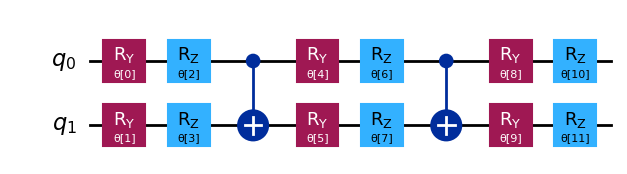

In [5]:
ansatz_1.decompose(reps=1).draw('mpl')

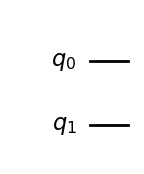

In [6]:
ansatz_2.decompose(reps= 1).draw('mpl')

#IDK why this is not working, checkit later, lets keep it with EfficientSU2

# VQE Implementation algorithm:

In [22]:
import numpy as np

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

# runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator


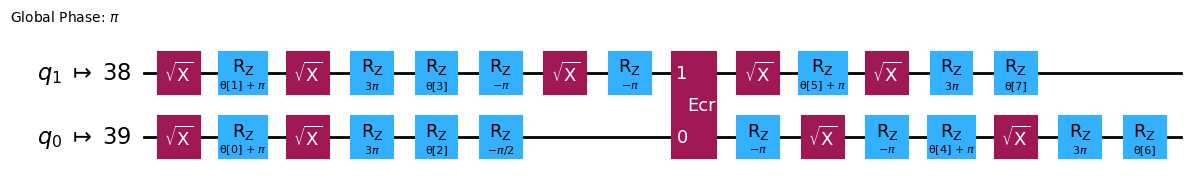

In [23]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz_1)
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [24]:
obs_isa = observable.apply_layout(layout=ansatz_isa.layout)

In [25]:
#fix this later (utilizing local variable in python under a function)
#bad practice but its okay for now
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = -1 * result[0].data.evs[0] #here the minus sign is to maximize the observable and not minimize

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

and choose the random point for beginning the VQE algorithm:

In [20]:
x0 = 2 * np.pi * np.random.random(ansatz_1.num_parameters)

first with a simulation:

In [32]:
from qiskit.primitives import Estimator

estimator = Estimator()
#estimator.options.default_shots = 10000

res = minimize(
    cost_func,
    x0,
    args=(ansatz_1, observable, estimator),
    method="cobyla",)



TypeError: BaseEstimatorV1.run() missing 2 required positional arguments: 'circuits' and 'observables'

In [32]:
# General imports
import numpy as np

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator


from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_ibm_runtime.fake_provider import FakeManilaV2




def cost_func(params, ansatz, hamiltonian, estimator, cost_history_dict):

    """Return cost function for optimization

    Parameters:
        params (ndarray): Array of ansatz parameters
        list_coefficients (list): List of arrays of complex coefficients
        list_labels (list): List of labels
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        obs (SparsePauliOp): Observable
        estimator (EstimatorV2): Statevector estimator primitive instance
        pm (PassManager): Pass manager
        callback_dict (dict): Dictionary to store callback information

    Returns:
        float: Cost function estimate
    """

    #ansatz + initial state ready to run over a Hamiltonian and being optimized


    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = -1 * result[0].data.evs[0]



    cost_history_dict['iters'] += 1
    cost_history_dict['prev_vector'] = params
    cost_history_dict['cost_value'] = 0
    
    return energy


def Initialize_VQE_hardware_EfficientSU2(sparse_pauli_hamiltonian, reps = 3,  backend_name= 'ibm_brisbane'):
    
    service = QiskitRuntimeService()
    

    ansatz = EfficientSU2(sparse_pauli_hamiltonian.num_qubits,
                      #su2_gates= ['rz'], #architecture of ibm_brisbane
                      
                       reps= reps #this is for the parity mapper
                      ) #try what happens if cz

    backend= FakeManilaV2()

    target = backend.target
    pm = generate_preset_pass_manager(target= target, optimization_level= 3)

    ansatz_isa = pm.run(ansatz)

    hamiltonian_isa = sparse_pauli_hamiltonian.apply_layout(layout= ansatz_isa.layout)

    initial_point = np.random.random(ansatz.num_parameters)

    with Session(backend= backend) as session:
        estimator= Estimator(session= session)
        estimator.options.default_shots= 10000

        cost_history_dict = {'iters' : 0,
                         'prev_vector' : None,
                         'cost_value' : 0}

        res = minimize(
            cost_func,
            initial_point,
            args=(ansatz_isa, hamiltonian_isa, estimator, cost_history_dict),
            method= 'cobyla'
        )
    
    return res

#lets try it:

In [33]:
reps = []
saturated_values = []

for i in range(1, 10):
    result = Initialize_VQE_hardware_EfficientSU2(observable, i)
    reps.append(i)
    saturated_values.append(result)


/tmp/ipykernel_10719/3837043170.py:82: DeprecationWarning: The 'session' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  estimator= Estimator(session= session)
/tmp/ipykernel_10719/3837043170.py:82: DeprecationWarning: The 'session' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  estimator= Estimator(session= session)
/tmp/ipykernel_10719/3837043170.py:82: DeprecationWarning: The 'session' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  estimator= Estimator(session= session)
/tmp/ipykernel_10719/3837043170.py:82: DeprecationWarning: The 'session' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.

In [34]:
y_values = []
ideal = []
for i in range(1, 10):
    y_values.append(abs(saturated_values[i - 2].fun))
    ideal.append(2 * np.sqrt(2))


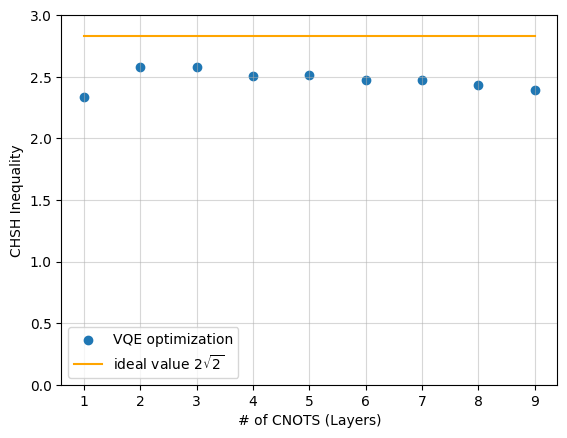

In [40]:
plt.scatter(reps, y_values, label= 'VQE optimization')
plt.plot(reps, ideal, label= r'ideal value $2 \sqrt{2}$', color = 'orange')
plt.ylim((0, 3))
plt.xlabel('# of CNOTS (Layers)')
plt.ylabel('CHSH Inequality')
plt.grid(alpha=0.5)
plt.legend()

plt.show()

In [45]:
rel_error = abs( 2* np.sqrt(2) - abs(results.fun))/ (2 * np.sqrt(2)) * 100

print(f'theoretical value: {2 * np.sqrt(2)} \n ')
print(f'VQE value: {abs(results.fun)}')
print(f'relative error: {rel_error} %')

theoretical value: 2.8284271247461903 
 
VQE value: 2.302734375
relative error: 18.586045408306692 %


In [41]:
# General imports
import numpy as np

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator


from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_ibm_runtime.fake_provider import FakeBrisbane




def cost_func(params, ansatz, hamiltonian, estimator, cost_history_dict):

    """Return cost function for optimization

    Parameters:
        params (ndarray): Array of ansatz parameters
        list_coefficients (list): List of arrays of complex coefficients
        list_labels (list): List of labels
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        obs (SparsePauliOp): Observable
        estimator (EstimatorV2): Statevector estimator primitive instance
        pm (PassManager): Pass manager
        callback_dict (dict): Dictionary to store callback information

    Returns:
        float: Cost function estimate
    """

    #ansatz + initial state ready to run over a Hamiltonian and being optimized


    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = -1 * result[0].data.evs[0]



    cost_history_dict['iters'] += 1
    cost_history_dict['prev_vector'] = params
    cost_history_dict['cost_value'] = 0
    
    return energy


def Initialize_VQE_hardware_EfficientSU2_pt2(sparse_pauli_hamiltonian, reps = 3,  backend_name= 'ibm_brisbane'):
    
    service = QiskitRuntimeService()
    

    ansatz = EfficientSU2(sparse_pauli_hamiltonian.num_qubits,
                      #su2_gates= ['rz'], #architecture of ibm_brisbane
                      
                       reps= reps #this is for the parity mapper
                      ) #try what happens if cz

    backend= FakeBrisbane

    target = backend.target
    pm = generate_preset_pass_manager(target= target, optimization_level= 3)

    ansatz_isa = pm.run(ansatz)

    hamiltonian_isa = sparse_pauli_hamiltonian.apply_layout(layout= ansatz_isa.layout)

    initial_point = np.random.random(ansatz.num_parameters)

    with Session(backend= backend) as session:
        estimator= Estimator(session= session)
        estimator.options.default_shots= 10000

        cost_history_dict = {'iters' : 0,
                         'prev_vector' : None,
                         'cost_value' : 0}

        res = minimize(
            cost_func,
            initial_point,
            args=(ansatz_isa, hamiltonian_isa, estimator, cost_history_dict),
            method= 'cobyla'
        )
    
    return res

#lets try it:

In [42]:
reps_pt2 = []
saturated_values_pt2 = []

for i in range(1, 10):
    result = Initialize_VQE_hardware_EfficientSU2(observable, i)
    reps_pt2.append(i)
    saturated_values_pt2.append(result)


/tmp/ipykernel_10719/3837043170.py:82: DeprecationWarning: The 'session' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  estimator= Estimator(session= session)
/tmp/ipykernel_10719/3837043170.py:82: DeprecationWarning: The 'session' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  estimator= Estimator(session= session)
/tmp/ipykernel_10719/3837043170.py:82: DeprecationWarning: The 'session' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  estimator= Estimator(session= session)
/tmp/ipykernel_10719/3837043170.py:82: DeprecationWarning: The 'session' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.

In [52]:
y_values_pt2 = []
ideal = []
for i in range(1, 10):
    y_values_pt2.append(abs(saturated_values_pt2[i - 1].fun))
    ideal.append(2 * np.sqrt(2))


[1, 2, 3, 4, 5, 6, 7, 8, 9]
[np.float64(2.6234), np.float64(2.6172), np.float64(2.5098000000000003), np.float64(2.5154), np.float64(2.4598), np.float64(2.5286), np.float64(2.4338), np.float64(2.3738), np.float64(2.4341999999999997)]


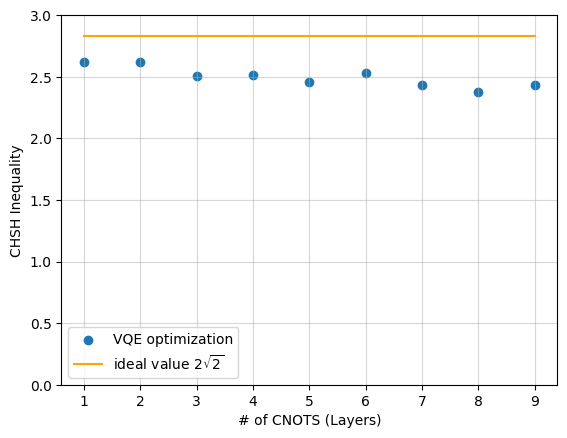

In [53]:
print(reps_pt2)
print(y_values_pt2)

plt.scatter(reps_pt2, y_values_pt2, label= 'VQE optimization')
plt.plot(reps_pt2, ideal, label= r'ideal value $2 \sqrt{2}$', color = 'orange')
plt.ylim((0, 3))
plt.xlabel('# of CNOTS (Layers)')
plt.ylabel('CHSH Inequality')
plt.grid(alpha=0.5)
plt.legend()

plt.show()

In [7]:
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import Statevector

qc = QuantumCircuit(2)


qc.x(0)

qc.h(range(2))


#qc.h(range(2))
Statevector(qc).draw('latex')


<IPython.core.display.Latex object>

# Part 2: Implementing the general CHSH problem via optimization problem

A continuación, implementaremos la desigualdad general de CHSH con el siguiente observable:

$$ S = U_0 \otimes V_0 + U_0 \otimes V_1 + U_1 \otimes V_0 - U_1 \otimes V_1$$

donde consideraremos el set de operadores ${U_0, U_1, V_0, V_1}$ que $\{ U \in \mathbb{U}(2) : \text{Spec}(U) = \{ \pm 1 \} \}$

Para ello, consideremos que de manera general (salvo una fase global) las matrices unitarias se pueden expresar de la siguiente manera:

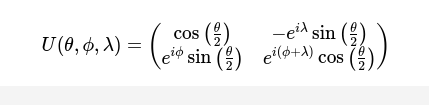

with the work done, we demonstrate that it is possible to express these unitary gates as it follows:

$$ U(\theta, \lambda) = \begin{pmatrix}
\cos(\theta / 2) & -e^{i \lambda} \sin(\theta / 2) \\
-e^{-i \lambda} \sin(\theta / 2) & -\cos(\theta / 2) 
\end{pmatrix} \\ = \cos(\theta / 2) Z  -\sin(\theta / 2) \cos(\lambda) X -\sin(\theta / 2) \sin(\lambda) Y $$



In [1]:
from qiskit.circuit.library import UGate
from qiskit.circuit import Parameter, ParameterVector, QuantumCircuit
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import SparsePauliOp
import numpy as np

parameter_dict = {}
#considerando esto, tenemos 4U * 2param = 8 free parameters
# el rango de cada parametros es de -pi a pi

for i in range(4):
    parameter_dict[f'theta_{i}'] = Parameter(name= f'theta_{i}')
    parameter_dict[f'lam_{i}'] = Parameter(name= f'lam_{i}')

# we set the gates with this parameters:
u_gates = {}

for i in range(4):
    t = parameter_dict[f'theta_{i}']
    l = parameter_dict[f'lam_{i}']

    u_gates[f'U_{i}'] = UGate(theta= t,
                              phi= np.pi - l,
                              lam= l,
                              label= f'U_{i}')

# we now generate the different observables:
#to achieve this, we decompose this in the pauli set in order to compute
#the expectation value:


observable_dict = {}

for i in range(4):
    t = parameter_dict[f'theta_{i}']
    l = parameter_dict[f'lam_{i}']

    z_coef = np.cos(t/2)
    y_coef = - np.sin(t/2) * np.sin(l)
    x_coef = - np.sin(t/2) * np.cos(l)
    
    U1_sparse = SparsePauliOp(['X', 'Y', 'Z'], [x_coef, y_coef, z_coef])

    observable_dict[f'U{i}_ob'] = U1_sparse




First Step done, now we are going to generate the observable:

$$ S = U_0 \otimes U_2 + U_0 \otimes U_3 + U_1 \otimes U_2 - U_1 \otimes U_3 $$

note: here $V_0 = U_2$ and $V_1 = U_3$

I'll be lazy and occupy this:

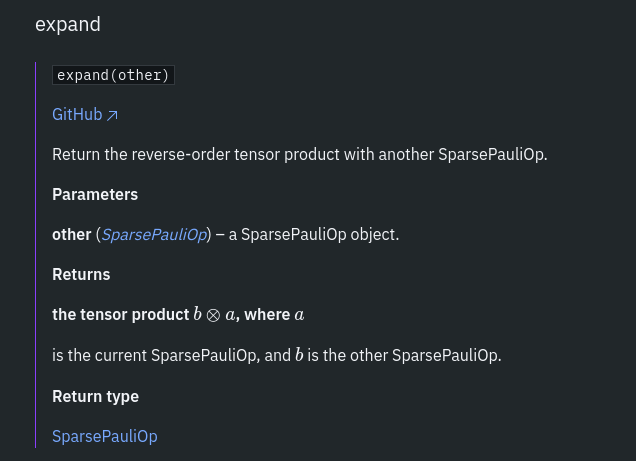

In [2]:
s1 = observable_dict['U2_ob'].expand(observable_dict['U0_ob'])
s3 = observable_dict['U2_ob'].expand(observable_dict['U1_ob'])
s2 = observable_dict['U3_ob'].expand(observable_dict['U0_ob'])
s4 = observable_dict['U3_ob'].expand(observable_dict['U1_ob'])

S_observable = s1 + s2 + s3 - s4



now lets compiled it to an arbitrary 2-qubit gates:

In [5]:
from qiskit_ibm_runtime import EstimatorV2
from qiskit_aer import AerSimulator


def two_qubit_schimdt_decomposition(alpha):
    qc = QuantumCircuit(2)
    qc.ry(theta= 2 * alpha,
           qubit= 0)
    qc.cx(0, 1)
    return qc


alpha = Parameter(name= 'alpha')

qc_schimdt_ansatz = two_qubit_schimdt_decomposition(alpha= alpha)


total_num_parameters = sum([len(gate.parameters) for gate in observable_dict.values()]) + qc_schimdt_ansatz.num_parameters

initial_param_vector = np.random.uniform(-np.pi, np.pi, total_num_parameters)

#the idea here is this is our function to maximize 
# in order to saturate the inequality...


cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}



def expected_CHSH_value(params, initial_circuit, CHSH_observable):

    estimator = EstimatorV2(mode= AerSimulator())
    estimator.options.default_shots = 10000


    pub = (initial_circuit, [CHSH_observable], [params])
    result = estimator.run(pubs= [pub]).result()
    final_exp_value = result[0].data.evs[0]


    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(final_exp_value)
    return -1 * final_exp_value #negative because we want it to maximize it




In [8]:
AerSimulator().available_methods()

('automatic',
 'statevector',
 'density_matrix',
 'stabilizer',
 'matrix_product_state',
 'extended_stabilizer',
 'unitary',
 'superop',
 'tensor_network')

In [ ]:
from scipy.optimize import minimize
    



res = minimize(
    cost_func,
    x0,
    args=(ansatz_isa, hamiltonian_isa, estimator),
    method="cobyla",
)

In [ ]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy


cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}


with Session(backend=backend) as session:
    estimator = Estimator(session=session)
    estimator.options.default_shots = 10000

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",
    )